# Franklin Prima Portfolio at the turn

In our notebook on [mutal fund drawdowns](https://github.com/stockviz/plutons/blob/master/mutual-fund-drawdown.R.ipynb), we saw how Franklin India Prima Fund drew down the least compared to other large midcap mutual funds. How did the portfolio change through time?

In [1]:
library(tidyverse)
library(ggthemes)
library(odbc)
library(plutoR)
library(quantmod)
library(PerformanceAnalytics)

options("scipen"=999)
options(stringsAsFactors = FALSE)
options(repr.plot.width=16, repr.plot.height=8)

source("config.R")
source("goofy/plot.common.R")
source("goofy/misc.common.R")

indices <- Indices()
mfi <- MutualFundsIndia()

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.1
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: xts
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Attaching package: ‘xts’

The following objects are masked from ‘package:dplyr’:

    first, last

Loading required package: TTR
Version 0.4-0 included new data defaults. See ?getSymbols.

Attaching package: ‘PerformanceAnalytics’

The following object is masked from ‘package:graphics’:

    legend

Registering fonts with R

Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine


Attaching package

### The big picture

How did the fund perform over the Midcap 150 TR index over a 5 year period?

In [2]:
indexName <- "NIFTY MIDCAP 150 TR"
schemeCode <- 100473
schemeName <- "Franklin India Prima"
startDate <- as.Date("2014-01-01")
endDate <- as.Date("2019-06-30")

In [3]:
#get the daily returns of the fund
navs <- data.frame(mfi$NavTimeSeries() %>%
        filter(SCHEME_CODE == schemeCode & TIME_STAMP >= startDate & TIME_STAMP <= endDate) %>%
        select(TIME_STAMP, NAV))
    
navXts <- dailyReturn(xts(navs$NAV, navs$TIME_STAMP))

#grab the benchmark
bm <- data.frame(indices$NseTimeSeries() %>%
    filter(NAME == indexName & TIME_STAMP >= startDate & TIME_STAMP <= endDate) %>%
    select(TIME_STAMP, CLOSE))

navXts <- merge.xts(navXts, dailyReturn(xts(bm$CLOSE, bm$TIME_STAMP)))
names(navXts) <- c("FUND", indexName)

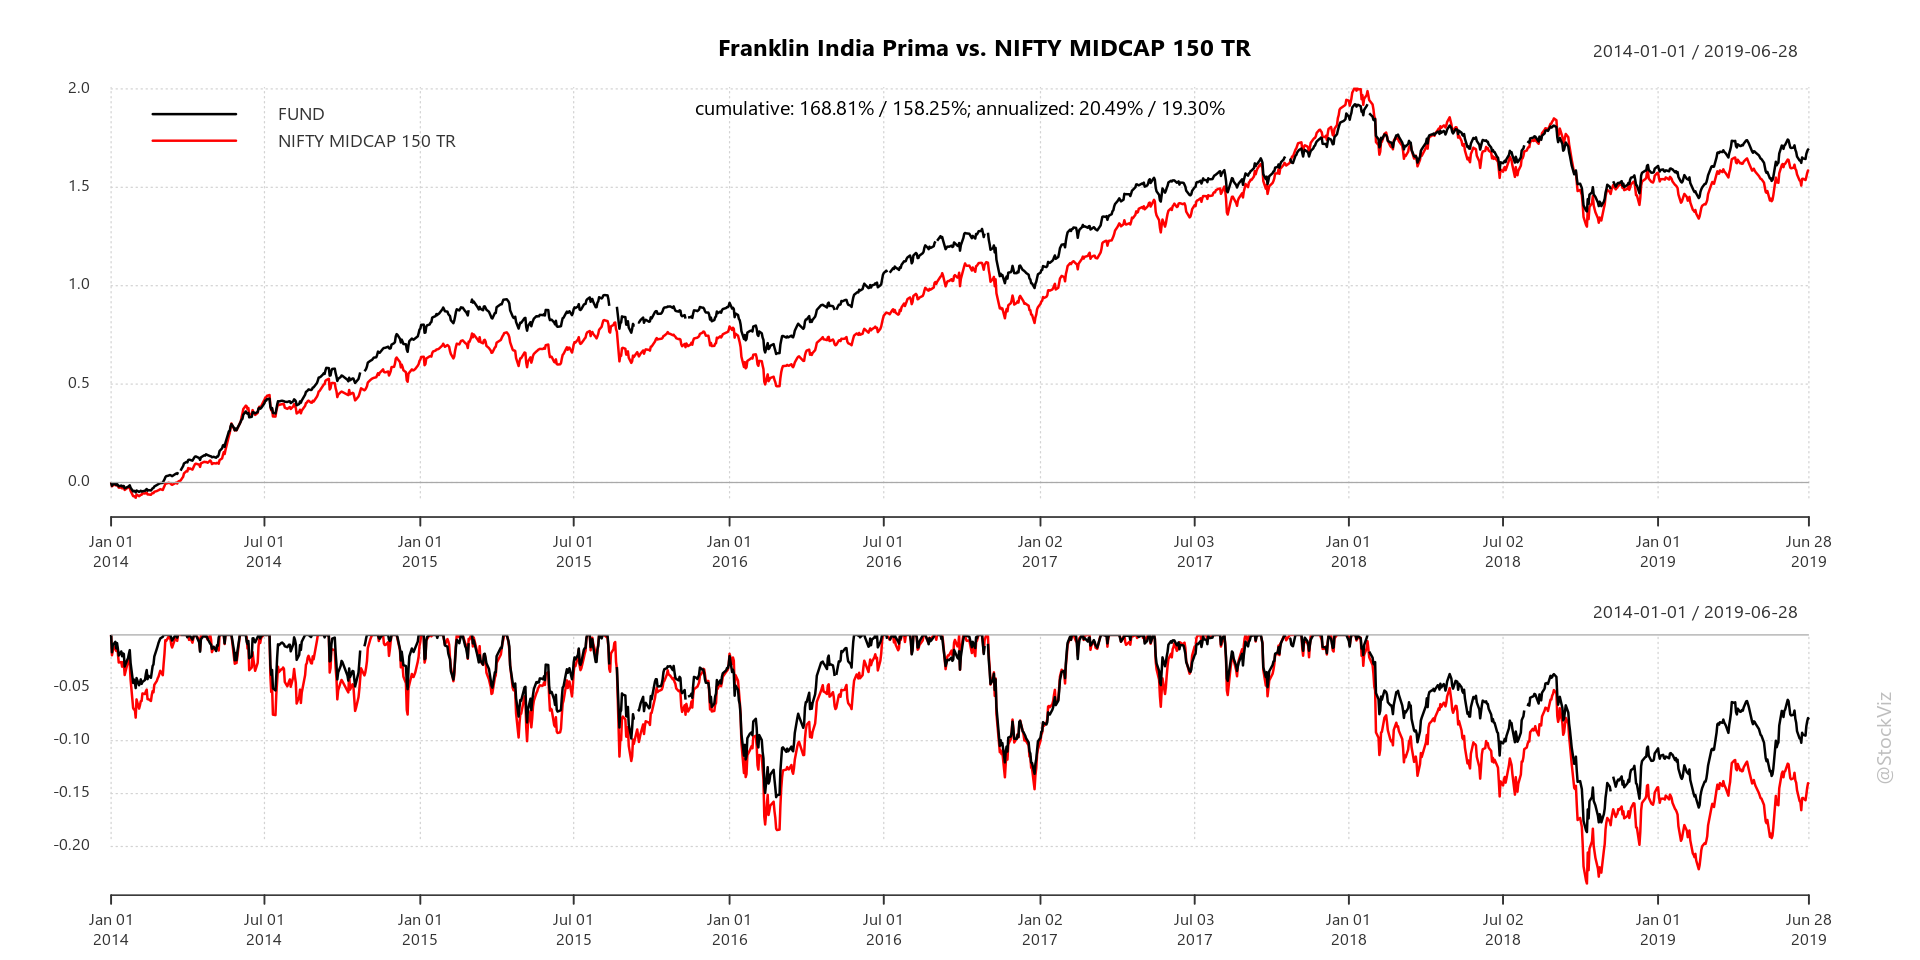

In [4]:
# plot the cumulative returns
Common.PlotCumReturns(navXts, sprintf("%s vs. %s", schemeName, indexName), "")

In [5]:
### How was the fund positioned going into 2018 vs. where it was in March 2019?

In [6]:
date1 <- as.Date("2017-12-31")
date2 <- as.Date("2019-03-31")

sectorAlloc1 <- mfi$Portfolio() %>%
    filter(SCHEME_CODE == schemeCode 
           & INSTRUMENT == 'EQUITY' 
           & !is.null(WEIGHTAGE)
           & WEIGHTAGE > 0
           & PORTFOLIO_DATE == date1
           & (INSTRUMENT_TYPE == 'STOCK' | INSTRUMENT_TYPE == 'E' | INSTRUMENT_TYPE == '' | is.null(INSTRUMENT_TYPE))) %>%
    group_by(INDUSTRY_BSE) %>%
    summarize(ALLOC = sum(WEIGHTAGE)) %>%
    arrange(desc(ALLOC)) %>%
    collect()

sectorAlloc1Df <- sectorAlloc1 %>%
    mutate(INDUSTRY_BSE = replace(INDUSTRY_BSE, INDUSTRY_BSE == '-' | is.na(INDUSTRY_BSE), 'UNK')) %>%
    as.data.frame()

sectorAlloc2 <- mfi$Portfolio() %>%
    filter(SCHEME_CODE == schemeCode 
           & INSTRUMENT == 'EQUITY' 
           & !is.null(WEIGHTAGE)
           & WEIGHTAGE > 0
           & PORTFOLIO_DATE == date2
           & (INSTRUMENT_TYPE == 'STOCK' | INSTRUMENT_TYPE == 'E' | INSTRUMENT_TYPE == '' | is.null(INSTRUMENT_TYPE))) %>%
    group_by(INDUSTRY_BSE) %>%
    summarize(ALLOC = sum(WEIGHTAGE)) %>%
    arrange(desc(ALLOC)) %>%
    collect()

sectorAlloc2Df <- sectorAlloc2 %>%
    mutate(INDUSTRY_BSE = replace(INDUSTRY_BSE, INDUSTRY_BSE == '-' | is.na(INDUSTRY_BSE), 'UNK')) %>%
    as.data.frame()


Warning message:
“Missing values are always removed in SQL.
Use `SUM(x, na.rm = TRUE)` to silence this warning
This warning is displayed only once per session.”

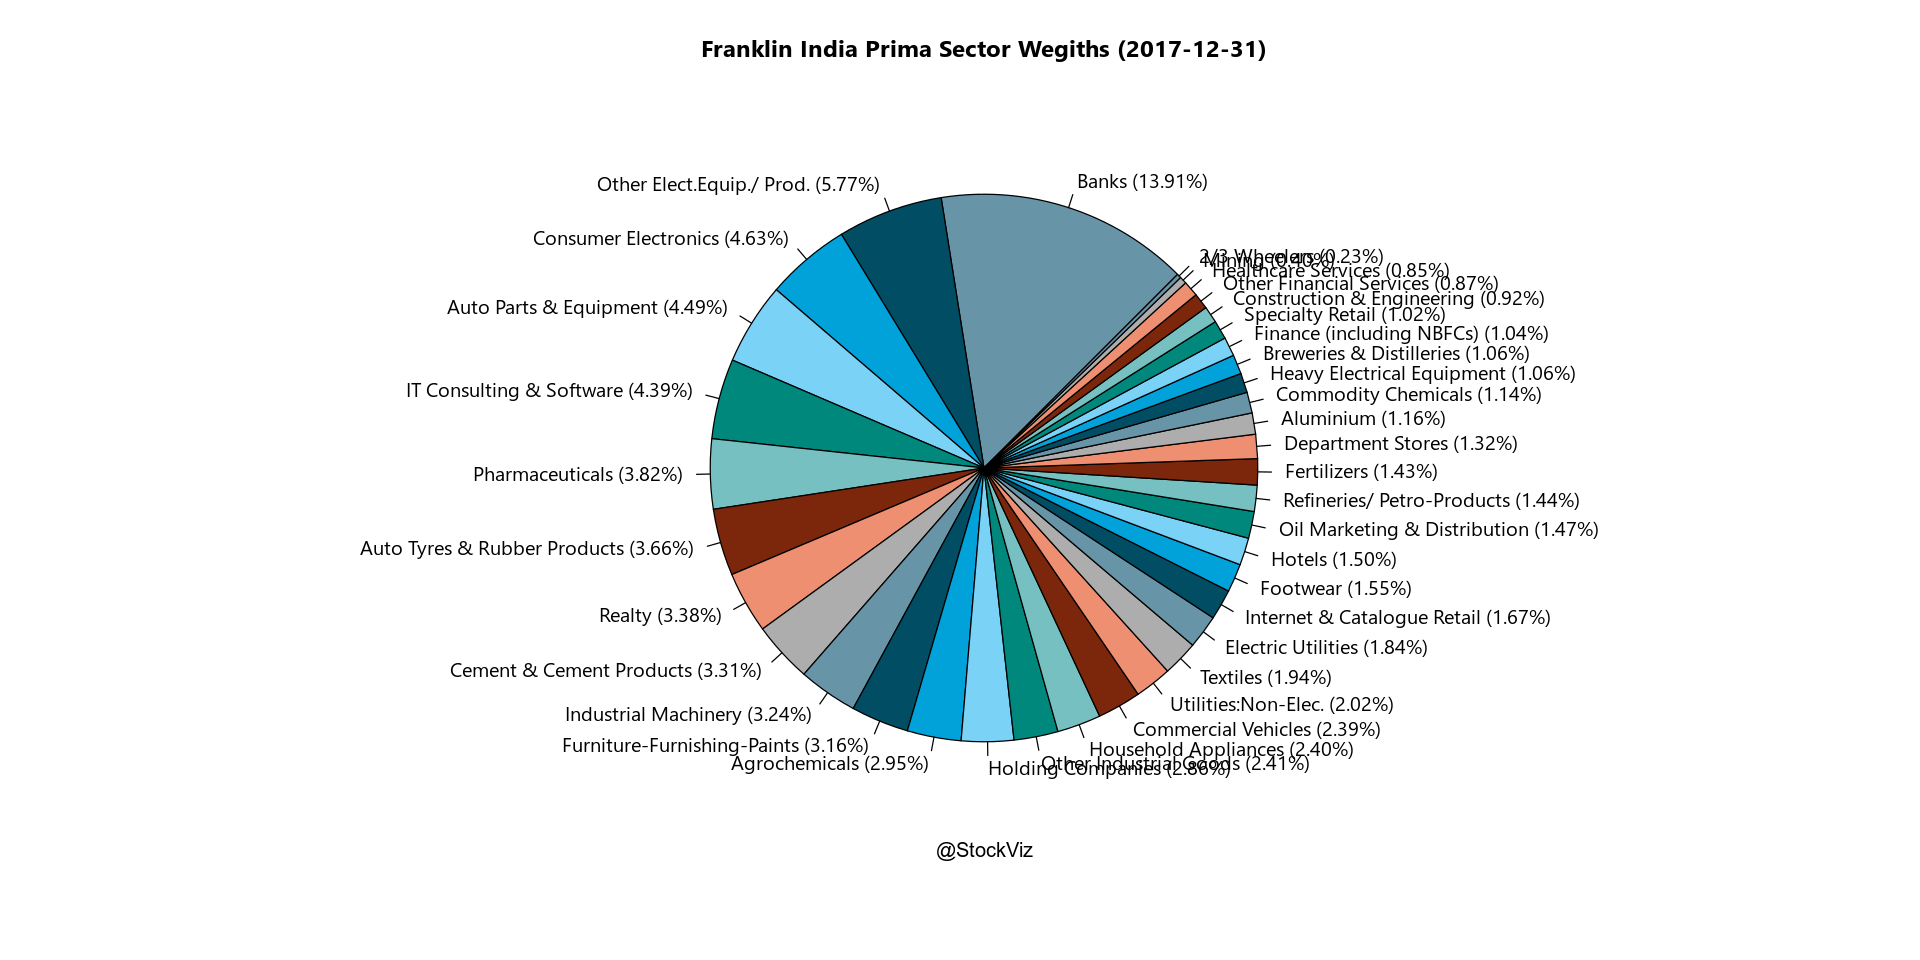

In [7]:
pie(sectorAlloc1Df$ALLOC, labels=sprintf("%s (%.2f%%)", sectorAlloc1Df$INDUSTRY, sectorAlloc1Df$ALLOC), 
    col=economist_pal()(9), 
    main=sprintf("%s Sector Wegiths (%s)", schemeName, date1), family='Segoe UI', init.angle=45)
mtext("@StockViz", side=1)

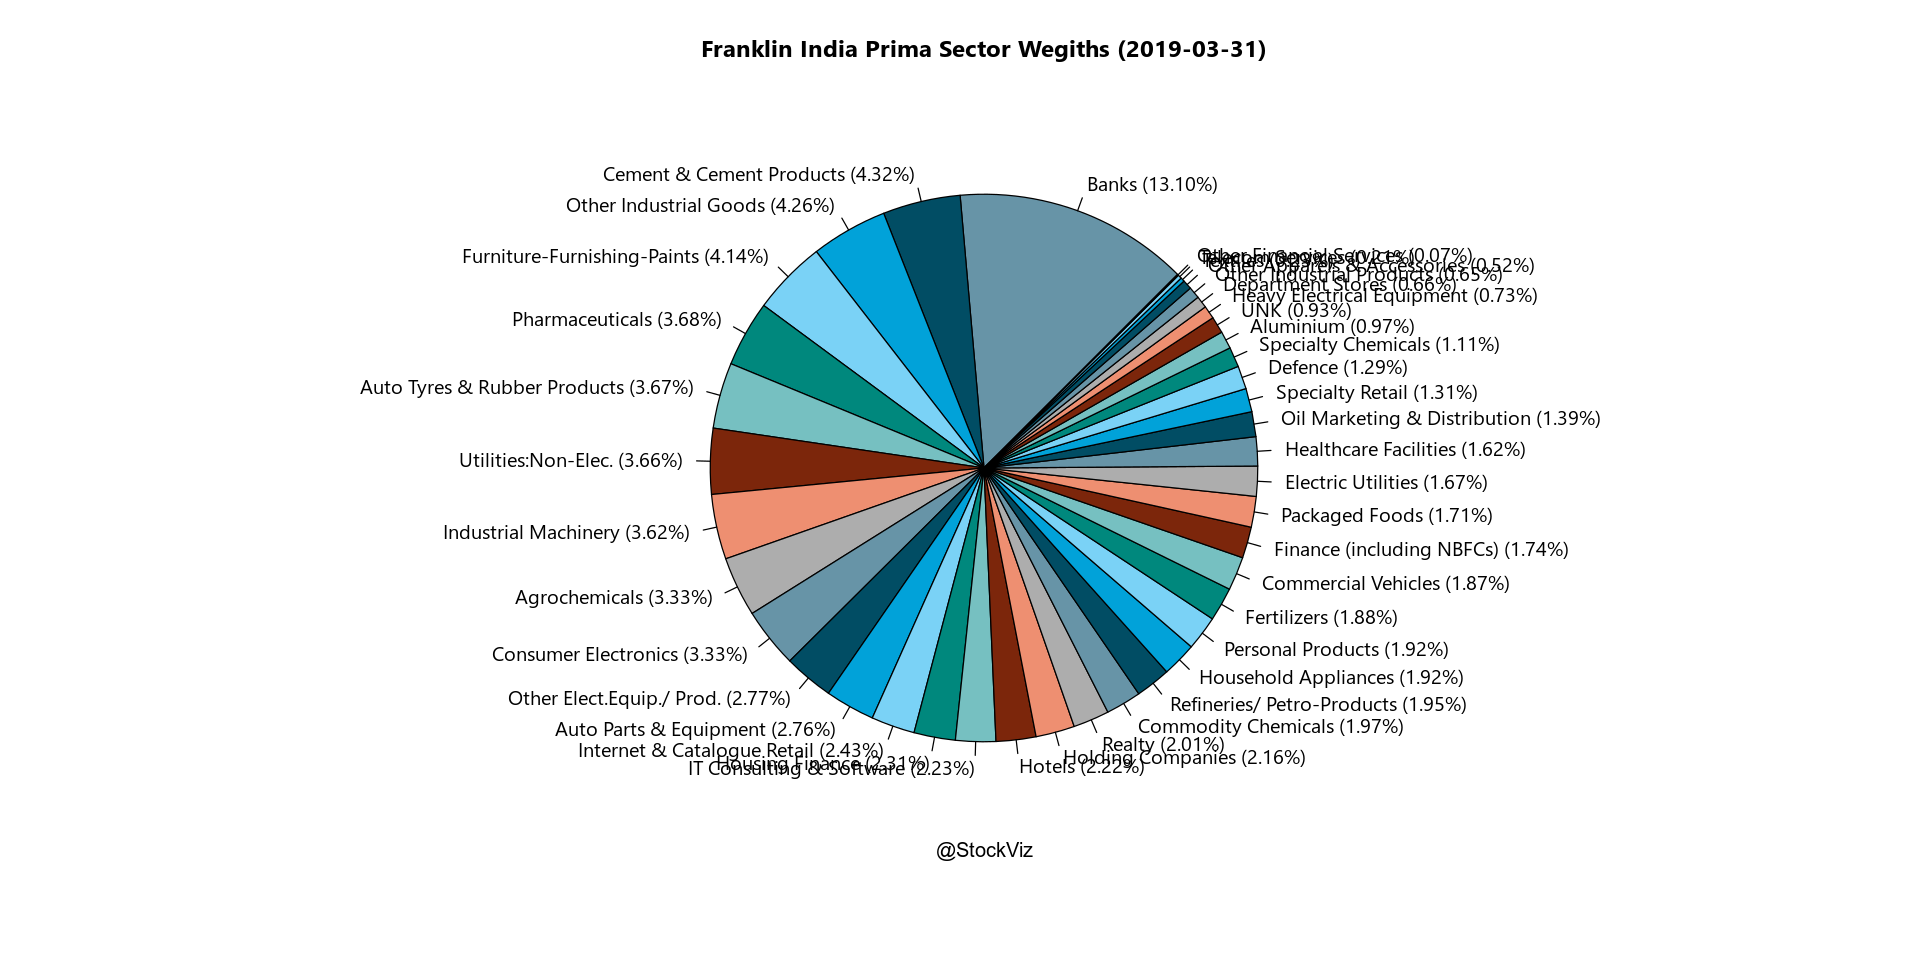

In [8]:
pie(sectorAlloc2Df$ALLOC, labels=sprintf("%s (%.2f%%)", sectorAlloc2Df$INDUSTRY, sectorAlloc2Df$ALLOC), 
    col=economist_pal()(9), 
    main=sprintf("%s Sector Wegiths (%s)", schemeName, date2), family='Segoe UI', init.angle=45)
mtext("@StockViz", side=1)